In [64]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

import os
import wandb
from datasets import FourierDataset
from utils import hash_dict
import pandas as pd
import seaborn as sns

In [230]:
criteria = {
    "k": 10,
    "dataset_size_coef": 1,
    "fix_seed": 3,
    "lr": 0.01,
}
n=10
project_path = "whfourier/LowDegree"
experiment_name = "low_degree"
dataset = FourierDataset(n, k=criteria["k"], n_samples=2**n, random_seed=criteria["fix_seed"], 
                        freq_sampling_method="single_deg", amp_sampling_method="constant")
int_freqs = dataset.get_int_freqs()

In [231]:
api = wandb.Api()

filters = {f'config.{k}': v for k, v in criteria.items()}
runs = api.runs(project_path, filters=filters)
print(len(runs))

10


In [232]:
def get_model_dir(config, experiment_name):
    data_directory = os.environ.get("EXPERIMENT_DATA") if "EXPERIMENT_DATA" in os.environ else os.getcwd()

    keys_to_ignore = ["num_epochs"]
    config_to_hash = {k:v for k, v in config.items() if k not in keys_to_ignore}
    config_hash = hash_dict(config_to_hash)

    model_dir = f"{data_directory}/checkpoints/{experiment_name}/{config_hash}/"

    return model_dir

In [233]:
# spectrum_list = []
epoch = 499
for run in runs:
    model_dir = get_model_dir(runs[0].config, experiment_name)
    # Load Fourier Spectrums
    spectrum_file = f'{model_dir}/spectrums{epoch}.npy'
    if os.path.exists(spectrum_file):
        spectrum_list.append(np.array(np.load(spectrum_file, allow_pickle=True))[:, int_freqs])

## Evolution histogram

Text(0.5, 23.52222222222222, 'Frequency degree')

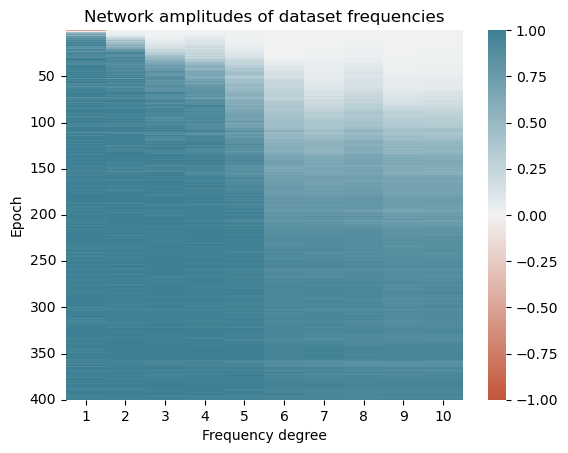

In [243]:
aggregated_spectrum = np.mean(np.array(spectrum_list), axis=0) * (criteria["k"] / 2**(n/2))
final_epoch = 400

data_range = 1
cmap = sns.diverging_palette(20, 220, as_cmap=True)

p = sns.heatmap(pd.DataFrame(aggregated_spectrum[:final_epoch]), 
            cmap=cmap, vmin=-data_range, vmax=data_range, cbar=True)
p.set_title("Network amplitudes of dataset frequencies")
p.set_yticks(range(50, 401, 50), list(range(50, 401, 50)))
p.set_xticks([i + 0.5 for i in range(criteria["k"])], list(range(1, criteria["k"]+1)))
p.set_ylabel("Epoch")
p.set_xlabel("Frequency degree")


In [236]:
len(spectrum_list)

30